# 1. App Review NLP work

This question uses the Apple App review dataset that you generated in the "Pulling online data" workshop. Your dataset should have at least 3-5 different applications, with data from a few countries.

**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

**1.3** Using any method you want (pre-trained models, dimensionality reduction, feature engineering, etc.) make the best **regression** model you can to predict the 5 star rating. Rate the accuracy in regression terms (mean squared error) and in classification terms (accuracy score, etc.)

**1.4** Do the same as in 1.3, but use a classification model. Are classification models better or worse to predict a 5-point rating scale? Explain in a few paragraphs and justify with metrics.


In [38]:
import requests
import json
import pandas as pd
import nltk

"""
From my 4.5 workshop

"""

app_ids={
    'amazon': '297606951',
    'messenger': '454638411',
    'wise': '612261027',
}
country_codes=[
    'ca',
    'us',
    'aus',
    'nz',
    'ie',
    'gb'
]

def is_error_response(http_response, seconds_to_sleep: float = 1) -> bool:
    """
    Returns False if status_code is 503 (system unavailable) or 200 (success),
    otherwise it will return True (failed). This function should be used
    after calling the commands requests.post() and requests.get().

    :param http_response:
        The response object returned from requests.post or requests.get.
    :param seconds_to_sleep:
        The sleep time used if the status_code is 503. This is used to not
        overwhelm the service since it is unavailable.
    """
    if http_response.status_code == 503:
        time.sleep(seconds_to_sleep)
        return False

    return http_response.status_code != 200

def get_json(url):# -> typing.Union[dict, None]:
    """
    Returns json response if any. Returns None if no json found.

    :param url:
        The url go get the json from.
    """
    response = requests.get(url)
    if is_error_response(response):
        return None
    json_response = response.json()
    return json_response


apps_r = []

def get_reviews_for(app_name, in_country, at_page=1):
    
    global app_ids
    app_id = app_ids[app_name]
    reviews = []
    
    while True:
        url = (f'https://itunes.apple.com/{in_country}/rss/customerreviews/page={at_page}/id={app_id}/sortby=mostrecent/json')
        json = get_json(url)

        if not json:
            return reviews

        feed = json.get('feed')
        
        try:
            if not feed.get('entry'):
                get_reviews_for(app_id, in_country, at_page + 1)
            reviews += [
                {
                    'review_id': entry.get('id').get('label'),
                    'app': app_name,
                    'title': entry.get('title').get('label'),
                    'author': entry.get('author').get('name').get('label'),
                    'author_url': entry.get('author').get('uri').get('label'),
                    'version': entry.get('im:version').get('label'),
                    'rating': entry.get('im:rating').get('label'),
                    'review': entry.get('content').get('label'),
                    'vote_count': entry.get('im:voteCount').get('label'),
                    'page': at_page
                }
                for entry in feed.get('entry')
                if not entry.get('im:name')
            ]
            at_page += 1
        except Exception as e:
            return reviews


In [39]:
nltk.download('words')
words = set(nltk.corpus.words.words())

for country in country_codes:
    for app in app_ids.keys():
        print("Fetching", app, "for", country)
        apps_r += get_reviews_for(app, country)
print("Done")

[nltk_data] Downloading package words to /home/jlmy/nltk_data...
[nltk_data]   Package words is already up-to-date!
Fetching amazon for ca
Fetching messenger for ca
Fetching wise for ca
Fetching amazon for us
Fetching messenger for us
Fetching wise for us
Fetching amazon for aus
Fetching messenger for aus
Fetching wise for aus
Fetching amazon for nz
Fetching messenger for nz
Fetching wise for nz
Fetching amazon for ie
Fetching messenger for ie
Fetching wise for ie
Fetching amazon for gb
Fetching messenger for gb
Fetching wise for gb
Done


In [40]:
apps = pd.DataFrame()
for app in apps_r:
    apps = apps.append(app, ignore_index=True)
print('Done')
apps['rating'] = apps['rating'].astype(int)
apps

Done


,app,author,author_url,page,rating,review,review_id,title,version,vote_count
0,amazon,mrkachi,https://itunes.apple.com/ca/reviews/id705420305,1.0,4,Having a hard time finding where I can reply t...,7091392821,Can’t respond to sellers,17.4.0,0
1,amazon,Seleena1995,https://itunes.apple.com/ca/reviews/id457357629,1.0,1,The new update won’t let me select other optio...,7091347680,Awful,17.4.0,0
2,amazon,Vavalulu citron,https://itunes.apple.com/ca/reviews/id301949810,1.0,1,I downloaded the app solely for the purpose of...,7090032691,Useless,17.4.0,0
3,amazon,Zikkom,https://itunes.apple.com/ca/reviews/id47695021,1.0,1,"You search for a certain brand, it shows you o...",7089279513,NO relevance!,17.4.0,0
4,amazon,vkkhgf,https://itunes.apple.com/ca/reviews/id999320194,1.0,5,Good,7088143871,Good,17.4.0,0
...,...,...,...,...,...,...,...,...,...,...
5685,wise,maaj1970,https://itunes.apple.com/gb/reviews/id175421421,10.0,5,A complete satisfaction in terms of client pea...,6299764481,Excellent app well designed,5.35,0
5686,wise,Evdybfhbfhbfthfgbfhko,https://itunes.apple.com/gb/reviews/id216475711,10.0,1,"Great when it works, but on numerous occasions...",6295435367,Unreliable,5.35,0
5687,wise,thailandia123456J,https://itunes.apple.com/gb/reviews/id1143975714,10.0,5,Muito boa já uso há muito tempo espetacular ob...,6295305850,Ótimo,5.35,0
5688,wise,LEPJ26,https://itunes.apple.com/gb/reviews/id1017044021,10.0,5,This is absolutely a brilliant option to trans...,6293821255,Best app to transfer money overseas,5.35,0


In [42]:
# To lowercase first
apps['review_processed'] = apps['review'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))
# Keep only english-recognized words
apps['review_processed'] = apps['review_processed'].apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()))

In [43]:
apps

,app,author,author_url,page,rating,review,review_id,title,version,vote_count,review_processed
0,amazon,mrkachi,https://itunes.apple.com/ca/reviews/id705420305,1.0,4,Having a hard time finding where I can reply t...,7091392821,Can’t respond to sellers,17.4.0,0,a hard time finding where i can reply to in th...
1,amazon,Seleena1995,https://itunes.apple.com/ca/reviews/id457357629,1.0,1,The new update won’t let me select other optio...,7091347680,Awful,17.4.0,0,the new update won ’ t let me select other ! f...
2,amazon,Vavalulu citron,https://itunes.apple.com/ca/reviews/id301949810,1.0,1,I downloaded the app solely for the purpose of...,7090032691,Useless,17.4.0,0,i the solely for the purpose of getting for an...
3,amazon,Zikkom,https://itunes.apple.com/ca/reviews/id47695021,1.0,1,"You search for a certain brand, it shows you o...",7089279513,NO relevance!,17.4.0,0,"you search for a certain brand , it you other ..."
4,amazon,vkkhgf,https://itunes.apple.com/ca/reviews/id999320194,1.0,5,Good,7088143871,Good,17.4.0,0,good
...,...,...,...,...,...,...,...,...,...,...,...
5685,wise,maaj1970,https://itunes.apple.com/gb/reviews/id175421421,10.0,5,A complete satisfaction in terms of client pea...,6299764481,Excellent app well designed,5.35,0,a complete satisfaction in of client peace of ...
5686,wise,Evdybfhbfhbfthfgbfhko,https://itunes.apple.com/gb/reviews/id216475711,10.0,1,"Great when it works, but on numerous occasions...",6295435367,Unreliable,5.35,0,"great when it works , but on numerous i have t..."
5687,wise,thailandia123456J,https://itunes.apple.com/gb/reviews/id1143975714,10.0,5,Muito boa já uso há muito tempo espetacular ob...,6295305850,Ótimo,5.35,0,boa tempo
5688,wise,LEPJ26,https://itunes.apple.com/gb/reviews/id1017044021,10.0,5,This is absolutely a brilliant option to trans...,6293821255,Best app to transfer money overseas,5.35,0,this is absolutely a brilliant option to trans...


**1.1** Using the bag-of-words or TF-IDF vector model (from SKLearn), cluster the reviews into 5 clusters. Measure the accuracy of the cluster overlap against the real review scores.

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5)
tfidf = tfidf_vectorizer.fit_transform(apps['review_processed'])

kmeans = KMeans(n_clusters=5).fit(tfidf)
print("Done")

Done


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import r2_score
import scipy as sc
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

COMPRESSED_SIZE=200



X_train, X_test, Y_train, Y_test = train_test_split(
    apps['review_processed'], 
    apps['rating'], 
    test_size=0.25, 
    random_state=30
)


vectorizer = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 5,
    stop_words = 'english'
)

tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)



clf = LinearSVC(random_state=0)
clf.fit(tf_x_train,Y_train)
y_test_pred=clf.predict(tf_x_test)

report=classification_report(Y_test, y_test_pred)
print("OLS R^2: ", r2_score(y_test_pred,Y_test))
print(report)

0.19.2
OLS R^2:  -1.1848474872636214
             precision    recall  f1-score   support

          1       0.47      0.27      0.35       531
          2       0.00      0.00      0.00       108
          3       0.00      0.00      0.00       115
          4       0.00      0.00      0.00        95
          5       0.47      0.91      0.62       574

avg / total       0.36      0.47      0.38      1423



/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Doing PCA
Doing TSNE


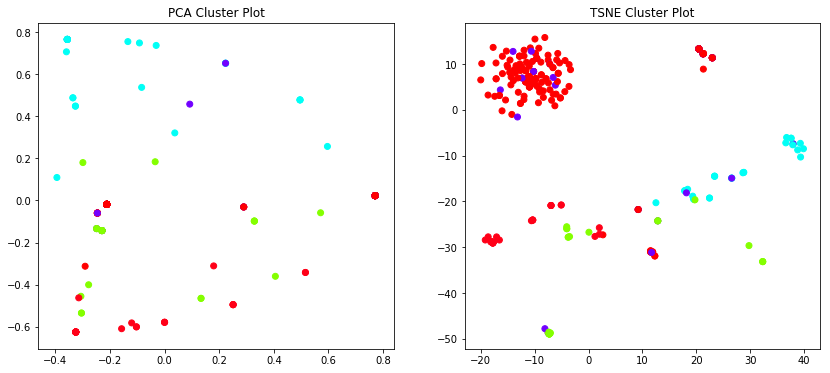

In [62]:
def plot_tsne_pca(data, labels):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=3000, replace=False)
    
    pca = PCA(n_components=5).fit_transform(data[max_items,:].todense())
    tsne = TSNE().fit_transform(pca)
    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    print("Doing PCA")
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    print("Doing TSNE")
    ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
    ax[1].set_title('TSNE Cluster Plot')
    
plot_tsne_pca(text, clusters)

**1.2** Now use a sentence embedding using on of the `gensim` pre-trained word embedding models to achieve the same in clustering. Get the best classification accuracy score you can on the 5-star review scale targer using all unsupervised methods you want.

## 2. Face data

Here let's apply manifold learning on some face data.

Use the following code:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
```

To get the `faces` dataset.

Use dimensionality reduction so that the darkness of the image is sorted in the first dimension as seen in this picture:

![](isofaces.png)

Then produce a picture similar to this one with your result

In [63]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will

/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/jlmy/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [65]:
faces

{'data': array([[109.333336 , 104.666664 ,  97.333336 , ...,  32.666668 ,
          25.333334 ,   8.       ],
        [  4.6666665,   9.333333 ,  16.333334 , ...,  60.666668 ,
          61.666668 ,  63.333332 ],
        [ 44.       ,  59.       ,  67.       , ..., 187.       ,
         186.66667  , 186.       ],
        ...,
        [ 94.333336 ,  89.333336 ,  82.       , ..., 127.       ,
         108.       ,  97.       ],
        [ 15.666667 ,  14.       ,  30.       , ...,  66.333336 ,
          62.333332 ,  60.666668 ],
        [ 93.       ,  89.       ,  91.       , ..., 245.66667  ,
         240.33333  , 175.66667  ]], dtype=float32),
 'images': array([[[109.333336 , 104.666664 ,  97.333336 , ...,  68.333336 ,
           52.       ,  70.666664 ],
         [ 96.333336 , 104.       , 102.       , ...,  77.333336 ,
           55.       ,  60.333332 ],
         [ 93.333336 ,  99.333336 ,  99.333336 , ...,  98.       ,
           81.       ,  75.333336 ],
         ...,
         [ 95.